<a href="https://colab.research.google.com/github/orekhovsky/YSDA/blob/main/ML_2_spring2025/Homeworks/8%20time%20series/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 5. Временные ряды.


Результат лабораторной работы &mdash; отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам &mdash; меньше проверять, вам &mdash; проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу &mdash; 10 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



In [1]:
pip install tbats -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.5 MB/s eta 0:00:00


In [ ]:
# pip uninstall numpy pmdarima -y
!pip install numpy==1.23.5 pmdarima

In [1]:
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels.api as sm
import pmdarima as pm
from tbats import TBATS

## 1. Данные

В качестве данных рассмотрим известный набор данных с параметрами погоды в одной точке земной поверхности, доступный нам с частотой дискретизации в 10 минут. Описание данных доступно по <a href="https://keras.io/examples/timeseries/timeseries_weather_forecasting/">ссылке</a>.

Скачаем данные

In [2]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
!wget {uri}

--2025-05-09 10:12:10--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.1s    

2025-05-09 10:12:10 (95.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]



In [3]:
zip_path = "jena_climate_2009_2016.csv.zip"
assert os.path.exists(zip_path), f"Download {uri}"

zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

Немного преобразуем данные, рассмотрев максимальное значение каждой величины за сутки.

In [4]:
weather_df = pd.read_csv(csv_path)
weather_df["Date"] = pd.to_datetime(weather_df["Date Time"], format="%d.%m.%Y %H:%M:%S")

weather_df_daily = weather_df.set_index("Date").resample('D').max().reset_index()
del weather_df_daily["Date Time"]
weather_df_daily = weather_df_daily.set_index('Date')
weather_df_daily.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date,,,,,,,,,,,,,,
2009-01-01,1000.87,-4.17,269.00,-5.36,94.8,4.48,4.09,0.49,2.55,4.09,1318.81,2.51,3.63,357.9
2009-01-02,1002.65,-2.12,271.12,-3.88,96.3,5.22,4.58,0.70,2.86,4.59,1298.51,3.87,6.13,358.8
2009-01-03,1002.49,-0.82,272.59,-6.09,93.9,5.75,3.87,2.86,2.41,3.86,1323.70,3.64,4.88,357.2
2009-01-04,992.93,-0.63,273.55,-2.26,93.9,5.83,5.17,1.53,3.27,5.25,1274.06,3.95,7.13,257.0
2009-01-05,997.54,-1.44,272.89,-2.45,93.2,5.49,5.10,0.83,3.23,5.18,1332.38,7.81,10.88,358.9


Теперь в каждой строчке датасета мы имеем максимальные значения за сутки. Например, в строчке `2012-12-22` в колонке `T (degC)` записана максимальная температура по Цельсию за данные сутки.

**Глобальная цель** в данном домашнем задании &mdash; прогнозирование максимальной температуры на день вперед. Например, 22 декабря нужно построить прогноз значения `T (degC)` за 23 декабря, используя при этом любые данные до 22 декабря включительно, но не используя никакие данные начиная с 23 декабря.

*Замечание*. Обратите внимание, что значения от 22 декабря доступны только по окончанию этого дня, плюс накладные расходы на поставку данных. Но для упрощения ситуации, допустим, что данные приходят мгновенно, а прогноз от нас ждут в начале суток 23 декабря, так что мы успеем подучить данные от 22 декабря, преобразовать их в признаки и применить нашу модель.

#### Задача 1. [0.25 балла]

Выделите таргет в отдельную переменную `pd.Series`. Значением таргета от 22 декабря должна быть максимальная температура за сутки 23 декабря, то есть то, что мы хотим прогнозировать.

In [5]:
target = weather_df_daily['T (degC)'].shift(-1)
target.tail()

,T (degC)
Date,
2016-12-28,4.55
2016-12-29,3.67
2016-12-30,5.21
2016-12-31,-4.82
2017-01-01,NaN


Разделите данные на обучающие и тестовые. В качестве тестового отрезка времени возьмите данные за последний год. Обратите внимание, что за 2016-10-26 и 2016-10-27 данных нет.

In [6]:
# weather_df_daily.reset_index().query("Date > '2016-12-28'")
last_date = weather_df_daily.index.max()
one_year_ago = last_date - pd.DateOffset(years=1)
X_train = weather_df_daily.reset_index().query("Date < @one_year_ago").drop('T (degC)',axis=1).set_index('Date')
X_test = weather_df_daily.reset_index().query("Date >= @one_year_ago").drop('T (degC)',axis=1).set_index('Date')
y_train = target.reset_index().query("Date < @one_year_ago").set_index('Date')
y_test = target.reset_index().query("Date >= @one_year_ago").set_index('Date')

## 2. Простая аналитика

#### Задача 2. [0.5 балла]

Произведите визуализацию всех временных рядов.

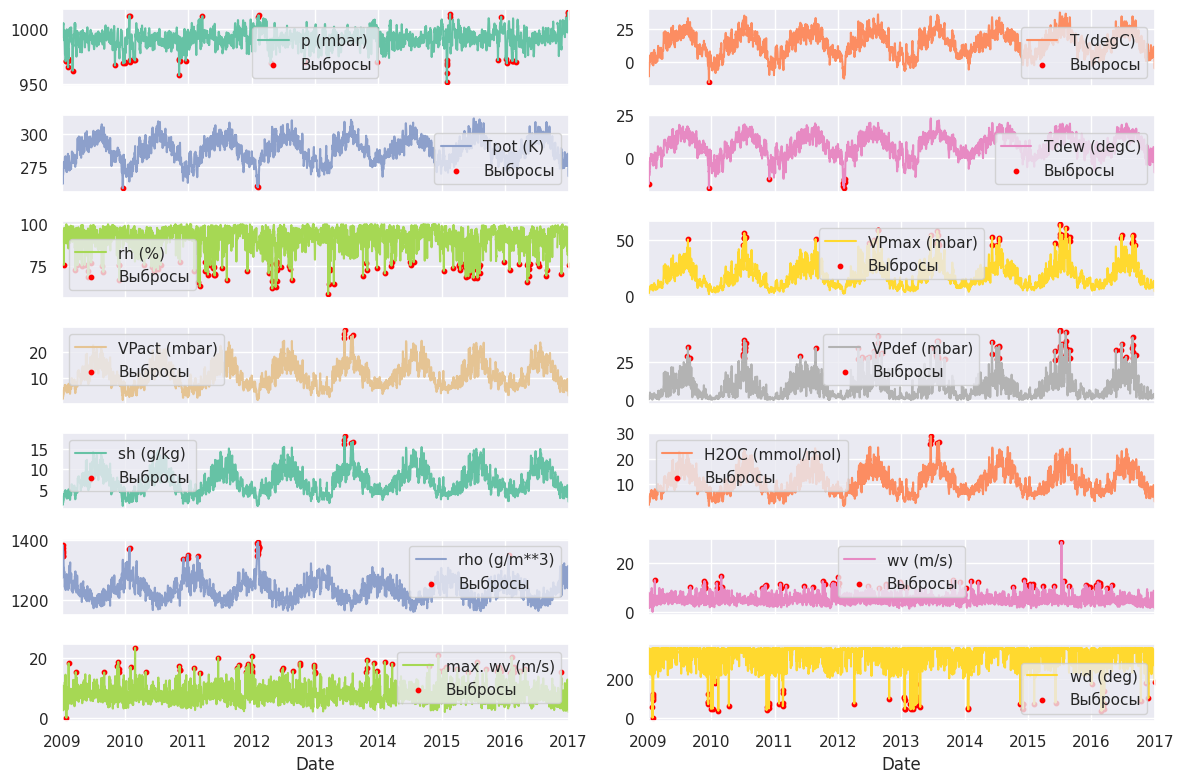

In [42]:
def detect_outliers(series, k=1.5):
  q1 = series.quantile(0.25)
  q3 = series.quantile(0.75)
  iqr = q3-q1
  low = q1-k*iqr
  high = q3+k*iqr
  return (series < low) | (series > high)

outlier_mask = weather_df_daily.apply(detect_outliers)
axes = weather_df_daily.plot(subplots=True, layout=(-1,2), figsize=(12,8))

for ax, col in zip(axes.flatten(), weather_df_daily.columns):
  out_dates = weather_df_daily.index[outlier_mask[col]]
  out_values = weather_df_daily.loc[out_dates, col]

  valid_mask = out_values.notna()
  out_dates = out_dates[valid_mask]
  out_values = out_values[valid_mask]

  if not out_dates.empty:
    ax.scatter(out_dates, out_values, color='red', s=10, label='Выбросы')
  ax.legend()

plt.tight_layout()
plt.show()


Имеются ли в данных выбросы? Если да, отфильтруйте данные. Не перестарайтесь, фильтруйте только более менее очевидные выбросы.

Подумайте над тем, какие значения ставить вместо выбросов. Учтите, что не все модели могут обрабатывать пропуски.

In [43]:
# будем ставить скользящее среднее

#### Задача 3. [0.5 балла]

Посчитайте матрицу корреляций по всем временным рядам без сдвигов (т.е. $corr(x_t, y_t)$) и визуализируйте ее

По временному ряду температуры выполните STL-разложение и визуализируйте полученные компоненты

**Выводы:**

## 3. Качество

#### Задача 4. [1 балл]

Напишите функции вычисления качества решения в задачи прогнозирования.
Качество решения будем описывать при помощи нескольких метрик качества:
  * mean_squared_error
  * mean_absolute_error
  * median_absolute_error

По всем тестовым данным посчитайте метрики качества baseline-решения &mdash; наивной модели. Попробуйте варианты:
- Naive(1): прогноз лагом порядка 1, т.е. последним доступным значением;
- Naive(2): прогноз лагом порядка 2;
- Naive(3): прогноз лагом порядка 3.

Обратите внимание на наличие пропусков в целевой переменной, как лучше поступить с ними при оценке качества и при построении прогноза?

Посчитайте по всем моделям эти же метрики по скользящим окнам из 4 и 8 недель:
- Берем тестовый промежуток и разбиваем его на окна, состоящие из 4 недель. Следующее окно сдвинуто относительно предыдущего на 1 день.
- По каждой модели считаем метрики одношагового прогноза на выбранном окне.
- Аналогично повторяем для окон из 8 недель.

Таким образом, для каждой модели получатся последовательности метрик по окнам. Постройте графики изменения качества прогноза.

**Выводы:**

#### Задача 5. [0.5 балла]

Скользящая валидация с фиксированным началом обучающего периода (*см. в лекциях вариант 1*) реализована в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">sklearn.model_selection.TimeSeriesSplit</a>:

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


ts_cv_1 = TimeSeriesSplit(n_splits=5, test_size=8*7)

Варианта с фиксированным размером обучающего датасета (*см. в лекциях вариант 2*) тоже можно добиться при помощи <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">sklearn.model_selection.TimeSeriesSplit</a>:

In [ ]:
ts_cv_2 = TimeSeriesSplit(n_splits=5, max_train_size=1000, test_size=8*7)

Пусть вы хотите добиться двух целей:
- Подобрать лучшую модель при помощи поиска оптимальных гиперпараметров.
- Получить несмещенную оценку качества полученной лучшей модели.

Для этих целей лучше не использовать одну и ту же кросс-валидацию, т.к. при подборе гиперепараметров происходит некоторая форма переоптимизации и качество может оказаться несколько завышенным.

С этой целью может подойти вложенная (nested) кросс-валидация, реализацию которого можно найти по <a href="https://github.com/roelbertens/time-series-nested-cv">ссылке</a>, а про читать про нее можно в [посте](https://xebia.com/blog/its-time-to-trust-your-predictions/).

Реализуйте вложенную кросс-валидацию. Продемонстрируйте ее работу, распечатав индексы обучающих и тестовых частей во внешнем и внутренних циклах.

*Замечание.* Демонстрацию можете сделать в виде вложенного цикла

## 4. Сведение к задаче регрессии

Для получения признакового описания для конкретного момента времени обычно применяют различные оконные функции к таблице данных, что позволяет сэкономить память и вычисления.
Но нужно помнить, что нельзя допустить просачивание информации из будущего, т.к. такие признаки вы не сможете вычислить в продакшне.




#### Задача 6. [0.5 балла]

Вычислите простые признаки вида описательных статистик (сумма, максимум, минимум, стандартное отклонение) по нескольким размерам окон. Признаки можно вычислять не только по температуре, но и по сопутствующим временным рядам.

#### Задача 7. [2 балла]

Обучите градиентый бустинг и обычный многослойный перцептрон с использованием написанного скользящего контроля.
- Используйте внутренний цикл кросс-валидации для подбора гиперпараметров, а внешний цикл для итоговой оценки качества.
- В качестве размера тестовой части во внешнем цикле возьмите 13 недель. Используйте 4 фолда, чтобы итоговой промежуток оценки качества составил примерно год.
- Не используете тестовую часть данных, отделенную в Задаче 1.
- Посчитайте качество на внешнем цикле кросс-валидации.

Визуализируйте прогнозы, полученные во внешнем цикле, сравнив их с истинными значениями ряда.

Переобучите лучшие модели на полном наборе обучающих данных и сделайте ими предсказания на тестовом промежутке. Посчитайте метрики.

Визуализируйте прогнозы, сравнив их с истинными значениями ряда.

#### Задача 8. [1 балл]

Генерировать признаки на этапе знакомства с данными &mdash; не очень интересное занятие.
В отрасли предпринято несколько попыток автоматизировать этот этап.

С помощью библиотеки <a href="https://tsfresh.com/">tsfresh</a> можно довольно быстро сгенерировать большое количество признаков на основе сырых данных временных рядов. Например, по скользящему окну с помощью можно вычислить статистики вида минимум, максимум, среднее, количество пиков и т.д.

Ознакомьтесь с данной библиотекой и сгенерируйте признаковое описание. Обратите внимание на функции
* `roll_time_series`
* `extract_features`

Сколько признаков вы получили? Как побороться с большим числом признаков?

Обучите модель на полном наборе обучающих данных, посчитайте ее качество на тестовых данных и постройте график прогноза в сравнении с истинными значениями.

**Выводы:**

## 5. Модель PatchTST

#### Задача 9. [2.5 балла]

Реализуйте модель [PatchTST](https://arxiv.org/abs/2211.14730).

In [ ]:
import torch
import torch.nn as nn
import math


class RevIN(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mean = None
        self.std = None

    def forward(self, x, mode="norm"):
        if mode == "norm":
            self._calc_statistics(x)
            x = self._normalize(x)
        elif mode == "denorm":
            x = self._denormalize(x)
        return x

    def _calc_statistics(self, x):
        # TODO: реализуйте
        self.mean = ...
        self.std = ...

    def _normalize(self, x):
        # TODO: реализуйте
        x = ...
        return x

    def _denormalize(self, x):
        # TODO: реализуйте
        x = ...
        return x


class PatchTST(nn.Module):
    def __init__(
        self,
        seq_len=336,
        pred_len=96,
        patch_len=16,
        stride=8,
        num_channels=1,
        d_model=128,
        n_heads=4,
        num_layers=3,
        dropout=0.2
    ):
        super().__init__()
        self.patch_len = patch_len
        self.stride = stride
        self.num_channels = num_channels

        # RevIN normalization
        self.revin = RevIN(num_channels)

        # Patching and Projection
        # TODO: реализуйте
        self.patch_num = ...
        self.input_proj = ...

        # Positional Encoding
        # TODO: реализуйте
        self.position_enc = ...

        # Transformer Encoder
        # TODO: реализуйте
        encoder_layer = ...
        self.encoder = ...

        # Output Layer
        # TODO: реализуйте
        self.output_layer = ...

    def create_patches(self, x):
        # Input: [batch, channels, seq_len]
        # TODO: реализуйте логику
        patches = ...
        return patches

    def forward(self, x):
        # x: [batch, channels, seq_len]
        # Apply RevIN normalization
        x = self.revin(x, "norm")

        # Create patches and reshape for channel independence
        # TODO: реализуйте
        patches = ...

        # Project patches
        # TODO: реализуйте
        projections = ...

        # Add positional encoding
        # TODO: реализуйте
        projections = ...

        # Transformer encoding
        # TODO: реализуйте
        encoded = ...

        # Flatten and predict
        # TODO: реализуйте
        output = ...

        # Denormalize output using RevIN
        output = self.revin(output, "denorm")

        return output

Проверим, что модель работает.

In [ ]:
model = PatchTST(
    seq_len=384,
    pred_len=1,
    patch_len=16,
    stride=8,
    num_channels=3,
    d_model=64,
    n_heads=4,
    num_layers=3
)

input_tensor = torch.randn(32, 3, 384)  # [batch, channels, seq_len]
output = model(input_tensor)  # [32, 3, 1]

#### Задача 10. [1 балл]

Обучите реализованную модель на полном наборе обучающих данных.

Посчитайте качество на тестовых данных и постройте график прогноза в сравнении с истинными значениями.

**Выводы:**

## 6. Итоговое сравнение

#### Задача 11. [0.25 балла]

Составьте итоговую таблицу сравнения качества прогнозов всех рассмотренных моделей по всем метрикам. Постройте график прогнозов для лучших моделей.

**Выводы:**